In [5]:
import torch

In [6]:
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
#loading the data
df=pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn (1).csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [9]:
churn_dist=df['Churn'].value_counts()
print(churn_dist)

Churn
No     5174
Yes    1869
Name: count, dtype: int64


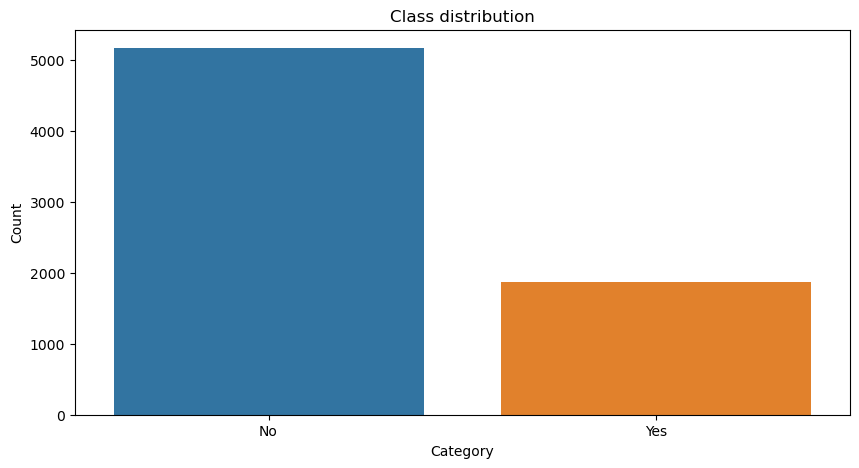

In [11]:
#visualization of class distribution
plt.figure(figsize=(10,5))
sns.barplot(x=churn_dist.index,y=churn_dist.values)
plt.title("Class distribution")
plt.xlabel("Category")
plt.ylabel("Count")
plt.show()

In [12]:
#from a perspective of analyzing churn, we need to understand the service provided better
service_columns=['MultipleLines','InternetService','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport',
                 'StreamingTV','StreamingMovies']
for col in service_columns:
    print("unique categories",df[col].unique())
    print("value counts",df[col].value_counts())

unique categories ['No phone service' 'No' 'Yes']
value counts MultipleLines
No                  3390
Yes                 2971
No phone service     682
Name: count, dtype: int64
unique categories ['DSL' 'Fiber optic' 'No']
value counts InternetService
Fiber optic    3096
DSL            2421
No             1526
Name: count, dtype: int64
unique categories ['No' 'Yes' 'No internet service']
value counts OnlineSecurity
No                     3498
Yes                    2019
No internet service    1526
Name: count, dtype: int64
unique categories ['Yes' 'No' 'No internet service']
value counts OnlineBackup
No                     3088
Yes                    2429
No internet service    1526
Name: count, dtype: int64
unique categories ['No' 'Yes' 'No internet service']
value counts DeviceProtection
No                     3095
Yes                    2422
No internet service    1526
Name: count, dtype: int64
unique categories ['No' 'Yes' 'No internet service']
value counts TechSupport
No         

In [17]:
def preprocessed_service_columns(df):
    df_preprocessed=df.copy()

    df_preprocessed['MultipleLines']=df_preprocessed['MultipleLines'].replace({'No phone service':'No'})

    internet_dependent_columns=['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport',
                 'StreamingTV','StreamingMovies']

    for column in internet_dependent_columns:
        df_preprocessed[column]=df_preprocessed[column].replace({'No internet service':'No'})

    df_preprocessed['HasPhoneService']=(df_preprocessed['PhoneService']=='Yes').astype(int)
    df_preprocessed['HasInternetService']=(df_preprocessed['InternetService']!='No').astype(int)

    return df_preprocessed

In [18]:
df_preprocessed=preprocessed_service_columns(df)

In [20]:
for col in service_columns:
    print(f"\n{col}:",df_preprocessed[col].unique())


MultipleLines: ['No' 'Yes']

InternetService: ['DSL' 'Fiber optic' 'No']

OnlineSecurity: ['No' 'Yes']

OnlineBackup: ['Yes' 'No']

DeviceProtection: ['No' 'Yes']

TechSupport: ['No' 'Yes']

StreamingTV: ['No' 'Yes']

StreamingMovies: ['No' 'Yes']


In [21]:
df_preprocessed['TotalServices']=(
    (df_preprocessed[['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport',
                 'StreamingTV','StreamingMovies']]=='Yes').sum(axis=1))

df_preprocessed['InternetType']=df_preprocessed['InternetService'].map({'DSL':1,'Fiber optic':2,'No':0})

In [23]:
binary_columns=['gender','Partner','Dependents','PhoneService','PaperlessBilling','OnlineSecurity',
                'OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']

multi_value_columns=['InternetService','Contract','PaymentMethod']

for column in binary_columns:
    df_preprocessed[column+'_encoded']=(df_preprocessed[column]=='Yes').astype(int)

df_encoded=pd.get_dummies(df_preprocessed,columns=multi_value_columns,prefix=multi_value_columns)

In [26]:
numerical_features=['tenure','MonthlyCharges','TotalCharges','TotalServices']

encoded_features=[col for col in df_encoded.columns if col.endswith('_encoded') 
                  or any(prefix in col for prefix in multi_value_columns)]

X=df_encoded[numerical_features+encoded_features].values
y=(df_encoded['Churn']=='Yes').astype(int).values

for i, feature in enumerate(numerical_features+encoded_features):
    print(f"{i}:{feature}")

0:tenure
1:MonthlyCharges
2:TotalCharges
3:TotalServices
4:HasInternetService
5:gender_encoded
6:Partner_encoded
7:Dependents_encoded
8:PhoneService_encoded
9:PaperlessBilling_encoded
10:OnlineSecurity_encoded
11:OnlineBackup_encoded
12:DeviceProtection_encoded
13:TechSupport_encoded
14:StreamingTV_encoded
15:StreamingMovies_encoded
16:InternetService_DSL
17:InternetService_Fiber optic
18:InternetService_No
19:Contract_Month-to-month
20:Contract_One year
21:Contract_Two year
22:PaymentMethod_Bank transfer (automatic)
23:PaymentMethod_Credit card (automatic)
24:PaymentMethod_Electronic check
25:PaymentMethod_Mailed check


In [30]:
categorical_columns=['gender','Partner','Dependents','PhoneService','MultipleLines','InternetService',
                     'OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV',
                     'StreamingMovies','Contract','PaymentMethod','PaperlessBilling']

encoders={}
for column in categorical_columns:
    encoders[column]=LabelEncoder()
    df[column+'_encoded']=encoders[column].fit_transform(df[column])

df['TotalCharges']=pd.to_numeric(df['TotalCharges'],errors='coerce')
df['TotalCharges'].fillna(0,inplace=True)

X=df[['tenure','MonthlyCharges','TotalCharges']+[col + '_encoded' for col in categorical_columns]].values
y=LabelEncoder().fit_transform(df['Churn'])

In [31]:
#class imbalance handling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [33]:
over=SMOTE(sampling_strategy=0.5)
under=RandomUnderSampler(sampling_strategy=0.8)

resampling=Pipeline([('over',over),('under',under)])

X_resampled,y_resampled=resampling.fit_resample(X,y)

unique, counts=np.unique(y_resampled,return_counts=True)
for label, count in zip(unique, counts):
    print(f"Class{label}:{count}samples({count/len(y_resampled):.2%})")

Class0:3233samples(55.55%)
Class1:2587samples(44.45%)
